In [14]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from collections import deque

In [15]:
# Enums
class Color(Enum):
    RED = 0
    BLUE = 1
    YELLOW = 2
    GREEN = 3
    BLACK = 4

class Label(Enum):
    DANGEROUS = 0
    SAFE = 1

COLOR_TO_RGB = {
    0 : (255, 0, 0),
    1 : (0, 0, 255),
    2 : (255, 255, 0),
    3 : (0, 255, 0),
    4 : (0, 0, 0)
}

In [16]:
# Image Generation
class Image: # USE THIS CLASS TO DISPLAY / CREATE IMAGE
    def __init__(self, data, label, third_wire):
        self.data = data
        self.label = label
        self.third_wire = third_wire

    def display(self):
        n = self.data.shape[0]
        image_data = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                curr_val = self.data[i][j]
                image_data[i][j] = COLOR_TO_RGB[curr_val]

        plt.imshow(image_data)
        plt.axis("off")
        plt.show()

class DataSet:
    def __init__(self):
        self.image_data = []
        self.labels = []
        self.third_wires = []

    def add_image(self, image, label, third_wire):
        """Add an image to the dataset using raw data"""
        self.image_data.append(image)
        self.labels.append(label.value)
        self.third_wires.append(third_wire) 

class ImageGenerator:
    """Generates N (M x M) images and writes to data"""
    def __init__(self, num_images, dimensions = 20, write_path = None, dataset = None, seed = None):
        self.dimensions = dimensions
        self.seed = seed
        random.seed(seed)
        for _ in range(num_images):
            data, label, third_wire = self.generate(write_path is not None)
            if dataset is not None:
                dataset.add_image(data, label, third_wire)

            # TODO: Write to data (may not be necessary, gen is really fast)
            if write_path is not None:
                pass

    def generate(self, write_ = False):
        """Generate a single image and label it appropriately"""
        n = self.dimensions
        image_data = np.full((n, n), Color.BLACK.value)
        colors = [Color.RED, Color.BLUE, Color.YELLOW, Color.GREEN]

        # Keep track of rows/cols that can be used
        valid_rows = list(range(n))
        valid_cols = list(range(n))

        # 1  = Color Row
        # -1 = Color Col
        pointer = random.choice([1, -1])
        label = Label.SAFE
        yellow_placed = False
        third_wire = None

        for i in range(4):
            # Select a unused color
            curr_color = random.choice(colors)
            colors.remove(curr_color)

            # Determine which should be cut (if dangerous)
            if i == 2:
                third_wire = curr_color
            
            # Handle marking an image as DANGEROUS if red is placed before yellow
            yellow_placed = yellow_placed or curr_color == Color.YELLOW
            if curr_color == Color.RED and not yellow_placed:
                label = Label.DANGEROUS

            if pointer == 1:
                rand_idx = random.choice(valid_rows)
                valid_rows.remove(rand_idx)
                self.color_row(rand_idx, curr_color, image_data)
            else:
                rand_idx = random.choice(valid_cols)
                valid_cols.remove(rand_idx)
                self.color_column(rand_idx, curr_color, image_data)
                
            pointer *= -1
        
        return image_data, label, third_wire
            

    def color_column(self, col, color, arr):
        """Color the given column of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[i][col] = color.value

    def color_row(self, row, color, arr):
        """Color the given row of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[row][i] = color.value

In [30]:
# Helper Functions
def load_image(dataset_obj, index):
    """Load a specific index of the dataset"""
    image_data = dataset_obj.image_data[index]
    label = dataset_obj.labels[index]
    third_wire = dataset_obj.third_wires[index]
    img = Image(image_data, label, third_wire)
    return img

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def train_test_validation_split(X, y, train_size = .8, test_size = .1, validation_size = .1):
    if train_size + test_size + validation_size != 1:
        print("Error: train + test + validation don't add up to 1.")
        return
    
    print(X.shape)
    examples, features = X.shape
    # Randomize Indexes
    index_array = np.arange(examples)
    random.shuffle(index_array)

    # Split up data
    num_training = int(examples * train_size)
    num_testing = int(examples * test_size)
    train_indices = index_array[:num_training]
    test_indices = index_array[num_training:(num_training + num_testing)]
    validation_indices = index_array[(num_training + num_testing):]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    X_validation = X[validation_indices]
    y_validation = y[validation_indices]

    return X_train, y_train, X_test, y_test, X_validation, y_validation

def one_hot_encode(image_data):
    """One-Hot encode matrix of examples"""
    if not isinstance(image_data, np.ndarray):
        image_data = np.array(image_data)

    num_colors = 4
    examples, rows, cols = image_data.shape
    encoded_shape = (examples, rows, cols, num_colors)
    encoded_image = np.zeros(encoded_shape)
    for i in range(examples):
        for j in range(rows):
            for k in range(cols):
                for l in range(num_colors):
                    if l == image_data[i, j, k]:
                        encoded_image[i, j, k, l] = 1
                    
    return encoded_image

def preprocess_data(image_data, label_data):
    """Preprocess and encode image and label data for model training"""
    image_data = one_hot_encode(image_data)
    label_data = np.array(label_data)
    flattened_data = image_data.reshape(image_data.shape[0], -1)
    flattened_data = np.c_[np.ones(len(flattened_data)), flattened_data] 
    return flattened_data, label_data
    
def plot_data(title, x_label, y_label, data):
    """Data should be either a list or tuple, where the list is a list of tuples.
    
    Tuple format: Data to be plotted, name of data"""
    fig, ax = plt.subplots()
    
    if isinstance(data, list):
        for d in data:
            ax.plot(d[0], label = d[1])
    else:
        ax.plot(data)
    ax.set_title(title)
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label)
    # ax.set_xticks([0, len(data)-1]) 
    # ax.set_yticks([])
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.show()
    

In [31]:
# Logistic Regression - Task 1
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_validation, y_validation, lr, epsilon):
        self.n = len(X_train)                                # of training examples
        self.d = len(X_train[0])                             # of features
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]      # Add column of 1s for W_0
        self.X_test = X_test
        self.X_validation = X_validation
        self.y_train = y_train                                  # Classification Labels
        self.y_test = y_test
        self.y_validation = y_validation
        self.weights = np.zeros(self.d)                # Current parameters / weights
        self.lr = lr                                    # Learning rate   
        self.epsilon = epsilon

    # Helper methods 
    def predict(self, inds=None):
        """Compute h_w(x_i) for the provided weight values"""
        if inds is None:
            inds = np.arange(len(self.X_train))
        
        dot_product = np.dot(self.X_train[inds], self.weights)
        return sigmoid(dot_product)

    def loss(self, y, p):
        """Compute the current value of average loss based on predictions"""
        return np.mean(-y * np.log(p) - (1 - y) * np.log(1 - p))

    
    # Gradient Descent
    def gd(self):
        """Run Gradient Descent to find `parameters` to minimize loss"""
        # Shuffle data before each epoch
        # random.shuffle(self.examples)
        # for i in range(len(self.examples)):
        #errors = self.loss(self.labels, self.predict())
        residuals = self.predict() - self.y_train
        gradient = np.dot(self.X_train.T, residuals)
        self.weights -= self.lr * gradient
            
    def sgd(self):
        """Run a single iteration of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            residual = self.predict(ind) - self.y_train[ind]
            gradient = residual * self.X_train[ind]
            self.weights -= self.lr * gradient

    def train_deterministic(self, epochs):
        """Run GD until # of epochs is exceeded OR convergence"""
        prev = float('inf')
        for epoch in range(epochs):
            self.gd()
            train_loss = self.loss(self.y_train, self.predict())
            if epoch % 5 == 0:
                print(f"{epoch} - Loss: {train_loss}")
                
            if prev - train_loss < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {train_loss}")
                break
            prev = train_loss
            
        print(f"{epoch} - Loss: {train_loss}")

    # Stochastic Gradient Descent
    def train_stochastic(self, epochs):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev = deque([float('inf')])
        self.train_losses = []
        self.validation_losses = []
        for epoch in range(epochs):
            self.sgd()

            train_loss = self.loss(self.y_train, self.predict())
            self.train_losses.append(train_loss)
            validation_loss = self.loss(self.y_validation, self.predict(np.arange(len(self.X_validation))))
            self.validation_losses.append(validation_loss)
            if epoch % 5 == 0:
                print(f"{epoch} - Train Loss: {train_loss}; Validation Loss: {validation_loss}")
            
            rolling_mean = sum(prev)/len(prev)
            if abs(rolling_mean - train_loss) < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {train_loss}")
                break
            prev.append(float(train_loss))
            if len(prev) > 5:
                prev.popleft()
                
        print(f"{epoch} - Loss: {train_loss}")

    # Model Evalutation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        if pred > .5:
            return 1
        elif pred < .5:
            return 0
        return np.random.choice([0, 1])
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(len(preds)):
            preds[i] = self.indicator(preds[i])
            
        return preds

    def validate(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = sigmoid(np.dot(self.X_train, self.weights))
        preds_train = self.get_pred_labels(probs_train)
        
        correct_train = [1 if pred == label else 0 for pred, label in zip(preds_train, self.y_train)]
        
        acc_train = round(sum(correct_train)/len(correct_train)*100, 2)
        print(f"TRAINING ACCURACY: {acc_train}%, {sum(correct_train)}/{len(correct_train)}")
        
        probs_test = sigmoid(np.dot(self.X_test, self.weights))
        preds_test = self.get_pred_labels(probs_test)
        
        correct_test = [1 if pred == label else 0 for pred, label in zip(preds_test, self.y_test)]
        
        acc_test = round(sum(correct_test)/len(correct_test)*100, 2)
        print(f"TESTING ACCURACY: {acc_test}%, {sum(correct_test)}/{len(correct_test)}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.train_losses, "Train"), (self.validation_losses, "Validation")])

In [32]:
# Generate and Preprocess Data
data = DataSet()
img_gen = ImageGenerator(5000, dataset = data)#, seed = 718067190)

lr = .1
epsilon = .01
image_data, label_data = preprocess_data(data.image_data, data.labels)
print(image_data.shape, label_data.shape)
ttv_split = train_test_validation_split(image_data, label_data) # train, test, and validation

(5000, 1601) (5000,)
(5000, 1601)


In [33]:
logistic = LogisticRegression(*ttv_split, lr, epsilon)
predictions = logistic.predict()
loss = logistic.loss(logistic.y_train, predictions)
#predictions

In [34]:
gd = logistic.train_stochastic(20000)
predictions = logistic.predict()
predictions = logistic.get_pred_labels(predictions)

0 - Train Loss: 1.4088987694385429; Validation Loss: 1.8175121487360006
5 - Train Loss: 0.6473255424534198; Validation Loss: 1.588114463838482
10 - Train Loss: 0.3832473425122033; Validation Loss: 1.614691586322638
15 - Train Loss: 0.2723424238594192; Validation Loss: 1.737822366253019
Stopping early at epoch 19 - Loss: 0.25857453259550006
19 - Loss: 0.25857453259550006


TRAINING ACCURACY: 89.15%, 3566/4000
TESTING ACCURACY: 76.2%, 381/500


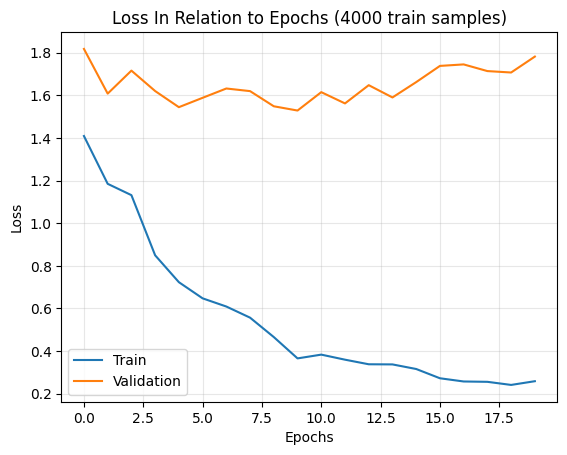

SUM OF WEIGHTS: 0.03230119031785314


In [35]:
logistic.validate()
print(f"SUM OF WEIGHTS: {sum(logistic.weights)}")

In [36]:
data.labels.count(0)

2509